# Stacked GRU for time series prediction

In this tutorial, we show how to quickly set up and train an RNN-GRU regression model with the deep4cast package. The example data constitutes of a monthly 26-dimensional multivariate time series.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_table

from deep4cast.forecasters import Forecaster
import deep4cast.topologies as topologies
import deep4cast.custom_metrics as metrics

%matplotlib inline

# Fix random number seed for reproducibility
np.random.seed(3) 

Using TensorFlow backend.


## Data preparation

The data for this example consists of a single 26-dimensional time series (i.e., we are in a multivariate forecasting scenario). 

Text(0,0.5,'Quantity')

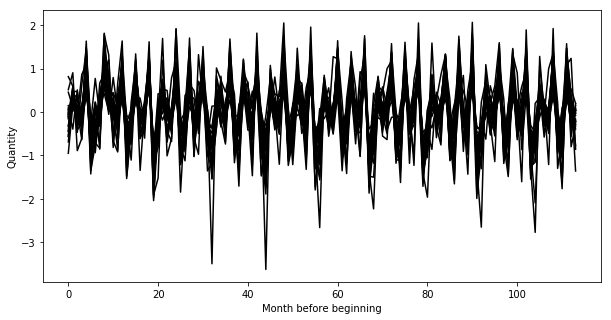

In [2]:
# Load the data from file
filename = '../data/example.csv'
df = read_table(filename, sep=',')
df_feat = df.apply(np.log1p)
df_feat = df_feat.diff()
df_feat = df_feat.dropna()

# Prepare the data set
data = df_feat.values
data = np.expand_dims(data, 0)

# We just need a small holdout dataset for evaluation purposes
holdout = 9
train_data = data[:,:-holdout,:]
test_data = np.expand_dims(df.astype('float32').values, axis=0)[:,-holdout:,:]
# Plot the dataset
plt.figure(figsize=(10,5))
plt.plot(data[0,:,:], 'k')
plt.xlabel('Month before beginning')
plt.ylabel('Quantity')

## Recurrent Neural Network Forecaster using GRU cells

In this example, we use a GRU-based Recurrent Neural Network that comes with residual connections.

In [3]:
topology = topologies.StackedGRU(units=32, num_layers=2)

In [4]:
forecaster = Forecaster(
    topology,
    lag=20,  # This is the number of time steps used to predict the future for each data point
    horizon=9,  # This is how many time steps into the future we want to produce
    lr=0.001,  # This is the learning rate for the optimizer
    patience=5
)

In [5]:
forecaster.fit(train_data, verbose=1)

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
Train on 67 samples, validate on 2 samples
Epoch 1/100
67/67 [==============================] - 1s 16ms/step - loss: 1.4274 - val_loss: 1.1472
Epoch 2/100
67/67 [==============================] - 0s 2ms/step - loss: 0.9860 - val_loss: 0.9232
Epoch 3/100
67/67 [==============================] - 0s 2ms/step - loss: 0.7777 - val_loss: 0.6182
Epoch 4/100
67/67 [==============================] - 0s 2ms/step - loss: 0.6000 - val_loss: 0.5720
Epoch 5/100
67/67 [==============================] - 0s 2ms/step - loss: 0.4387 - val_loss: 0.3944
Epoch 6/100
67/67 [==============================] - 0s 2ms/step - loss: 0.3144 - val_loss: 0.3198
Epoch 7/100
67/67 [==============================] - 0s 2ms/step - loss: 0.2174 - val_loss: 0.1040
Epoch 8/100
67/67 [==============================] - 0s 2ms/step - loss: 0.1203 - val_loss: -0.0414
Epoch 9/100
67/67 [==============================] - 0s 2ms/step - loss: 0.0470 

Text(0,0.5,"['Loss', 'Validation Loss']")

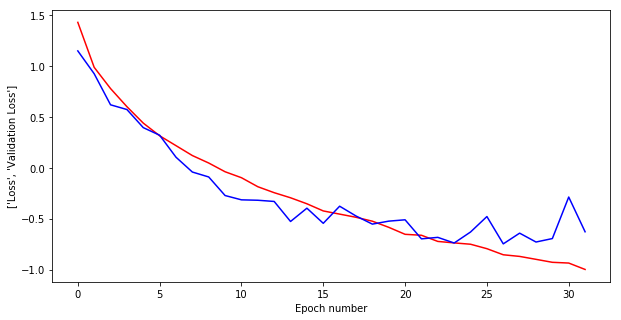

In [11]:
plt.figure(figsize=(10,5))
plt.plot(forecaster.history.epoch, forecaster.history.history['loss'], 'r')
plt.plot(forecaster.history.epoch, forecaster.history.history['val_loss'], 'b')
plt.xlabel('Epoch number')
plt.ylabel(['Loss', 'Validation Loss'])

In [12]:
predictions = forecaster.predict(data=train_data, n_samples=1000)  # Draw 100 samples for predictions

In [13]:
samples = predictions['samples'].squeeze()
samples = np.cumsum(samples, axis=1) + np.log1p(df.values[-holdout-1])
samples = np.expm1(samples)
predictions['mean'] = np.mean(samples, axis=0)
predictions['samples'] = samples
predictions['lower_quantile'] = np.percentile(samples, q=5, axis=0)
predictions['upper_quantile'] = np.percentile(samples, q=95, axis=0)

One meaningful way of evaluating model performance is the Mean Absolute Percentage Error (MAPE), which we use here to see how well we are doing.

In [9]:
print('MSE: {}'.format(round(metrics.mse(predictions['mean'], test_data[0,:,:]), 2)))
print('MAPE: {}%'.format(round(metrics.mape(predictions['mean'], test_data[0,:,:]), 2)))
print('SMAPE: {}%'.format(round(metrics.smape(predictions['mean'], test_data[0,:,:]), 2)))

MSE: 2249316619.52
MAPE: 29.1%
SMAPE: 22.95%


We can plot the forecasts for all 26 individual time series together with the 5th and 95 percentile forecast.

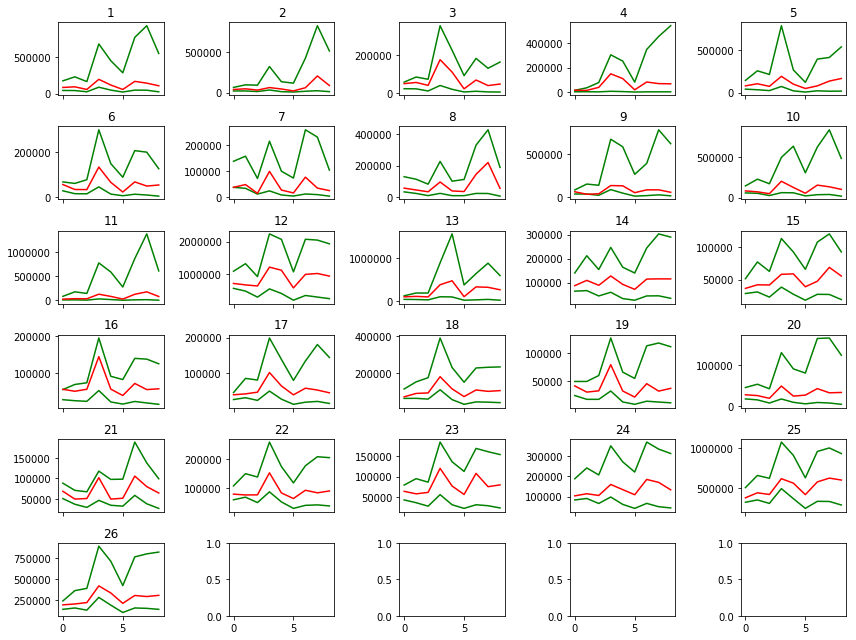

In [10]:
ncols = 5
fig, axes = plt.subplots(nrows=26//ncols+1, ncols=ncols, sharex=True, figsize=(12, 9))
for ax, ya, yl, yu, title in zip(axes.flat, 
                             test_data[0,:,:].T,
                             predictions['lower_quantile'][:,:].T,
                             predictions['upper_quantile'][:,:].T,
                             range(1,26+1)):
    ax.plot(yl, 'g-')
    ax.plot(yu, 'g-')
    ax.plot(ya, 'r-')
    ax.set_title(title)

plt.tight_layout()